# 09C. Genetic algorithm

### Mingyang Lu

### 3/29/2024

# Genetic Algorithm

Genetic algorithm (GA) is a stochastic method for global optimization, which is inspired by the process of natural selection. The method allows to sample a wide range of variables so that global optimum can be found. A genetic algorithm requires

(1) A genetic representation of the solution, *e.g.*, a vector representation of the variables.
(2) A fitness function to maximize/minimize. This is essentially the scoring function for the optimization problem.

After defining the genetic representation and the fitness function, we initialize a population of solutions and improve it through iterative application of the mutation, crossover and selection operators. In some problems, another operator inversion may also be used.


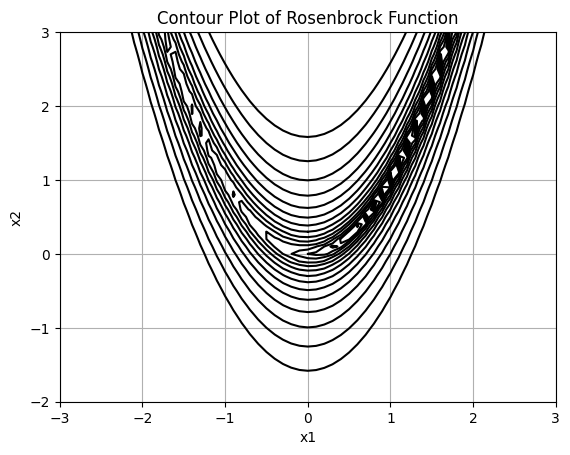

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f_rosenbrok(x):
    return 100 * (x[0]**2 - x[1])**2 + (1 - x[0])**2

x_all = np.arange(-3, 3.1, 0.1)
y_all = np.arange(-2, 3.1, 0.1)
x, y = np.meshgrid(x_all, y_all)
z = f_rosenbrok([x, y])

plt.contour(x, y, z, levels=10**(np.arange(-2, 2.6, 0.2)), colors='black')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of Rosenbrock Function')
plt.grid(True)
plt.show()

The function has a minimum at (1,1), but it is hard to be found because of the function values drastically decrease in a narrowly range. Rosenbrock's function has been used to test optimization algorithms. We illustrate the utilization of GA in this simple example. Here, we use a vector $(x_1, x_2)$ for the genetic representation and the function *f_rosenbrok* as the fitness function. For crossover, we take two solutions and randomly swap the variables so that we generate two new solutions (offsprings). For mutation, we randomly pick one variable and perform a small change (sampled from a uniform distribution) to the variable. We first **initialize** *np* number of randomly sampled parent solutions. Then, we perform **crossover** and **mutation** (the ratio of controlled by *rate_x*) to generate another *np* offspring solutions. We then select the best *np* solutions (according to the fitness function) from both the parent and offspring solutions (the **selection** process). That concludes one generation of the GA. We repeat the whole process multiple generations to obtain better solutions. 

In [2]:
# GA implementation (func is minimized)
def ga_opt(n, func, nparents, rate_x, ngen, xrange, dx_ratio):
    # n: number of variables
    # func: function to be optimized
    # nparents: number of parents
    # rate_x: rate of crossover
    # ngen: number of generations
    # xrange: variable ranges (matrix of n x 2)
    # dx_ratio: dx step size chosen as a % of xrange
    
    nparents = nparents + nparents % 2  # Ensure nparents is even
    dx_max = (xrange[:, 1] - xrange[:, 0]) * dx_ratio
    
    # Initialization
    x_parent = np.random.uniform(xrange[:, 0], xrange[:, 1], size=(nparents, n))
    s_parent = np.apply_along_axis(func, 1, x_parent)
    
    x_offspring = np.zeros((nparents, n))
    s_keep = np.zeros((ngen, nparents))
    
    for i in range(ngen):
        # New generation
        ind_ran = np.random.permutation(nparents)
        for j in range(0, nparents, 2):
            x1 = x_parent[ind_ran[j]]
            x2 = x_parent[ind_ran[j+1]]
            if np.random.uniform() < rate_x:
                # Crossover
                x_offspring[j:j+2] = crossover_opt(n, x1, x2)
            else:
                # Mutation
                x_offspring[j] = mutation_opt(n, x1, xrange, dx_max)
                x_offspring[j+1] = mutation_opt(n, x2, xrange, dx_max)
        
        # Scoring
        s_offspring = np.apply_along_axis(func, 1, x_offspring)
        
        # Selection
        x_all = np.vstack((x_parent, x_offspring))
        s_all = np.concatenate((s_parent, s_offspring))
        rank_all = np.argsort(s_all)
        ind_keep = rank_all[:nparents]
        
        x_parent = x_all[ind_keep]
        s_parent = s_all[ind_keep]
        
        x_best = x_all[rank_all[0]]
        s_best = s_all[rank_all[0]]
        s_keep[i] = s_parent
        
    return {'x': x_best, 's': s_best, 'x_parent': x_parent, 's_keep': s_keep}


def crossover_opt(n, x1, x2):
    # n: number of variables
    # x1, x2: variables (vector of size n)
    w1 = np.random.randint(0, 2, size=n)
    x1_new = x1 * w1 + x2 * (1 - w1)
    x2_new = x2 * w1 + x1 * (1 - w1)
    return np.vstack((x1_new, x2_new))


def mutation_opt(n, x, xrange, dx_max):
    # n: number of variables
    # x: variables (vector of size n)
    # xrange: matrix of n by 2 (variable boundary)
    # dx_max: maximum step size
    ind = np.random.randint(0, n)
    x_new = x.copy()
    x_new[ind] += np.random.uniform(-dx_max[ind], dx_max[ind])
    x_new[ind] = np.clip(x_new[ind], xrange[ind, 0], xrange[ind, 1])
    return x_new

By the following test, we can obtain solutions very close to the global minimum of the Rosenbrok function. But the performance depends on the choice of the GA parameters: crossover rate, number of parent solutions, and the number of generations. The performance also highly depends on the operations of crossover and mutation.

Best x: [1.06448436 1.13502943]
Best score: 0.004520174779212826


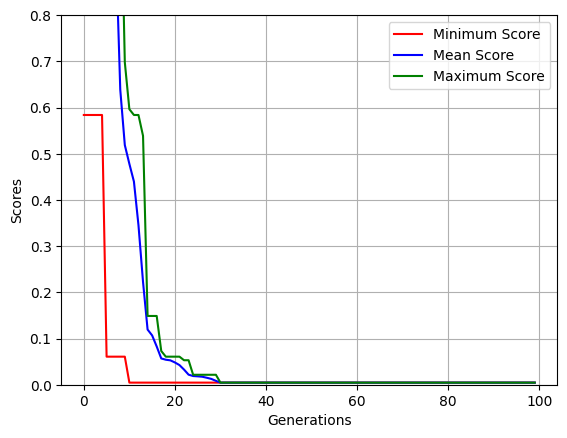

In [3]:
np.random.seed(3)

xrange = np.array([[-3, 3], [-3, 3]])
ngen = 100
results = ga_opt(n = 2, func = f_rosenbrok, nparents = 50, rate_x = 0.7, ngen = ngen, xrange = xrange, dx_ratio = 0.1)

print("Best x:", results['x'])
print("Best score:", results['s'])

s = results['s_keep']
generations = np.arange(ngen)

plt.plot(generations, np.apply_along_axis(np.min, 1, s), color='red', label='Minimum Score')
plt.plot(generations, np.apply_along_axis(np.mean, 1, s), color='blue', label='Mean Score')
plt.plot(generations, np.apply_along_axis(np.max, 1, s), color='green', label='Maximum Score')
plt.xlabel('Generations')
plt.ylabel('Scores')
plt.ylim((0, 0.8))  
plt.legend()
plt.grid(True)
plt.show()


Below we also apply GA to optimize the Himmelblau's function.

Best x: [-2.80603347  3.13222844]
Best score: 5.987743544292717e-05


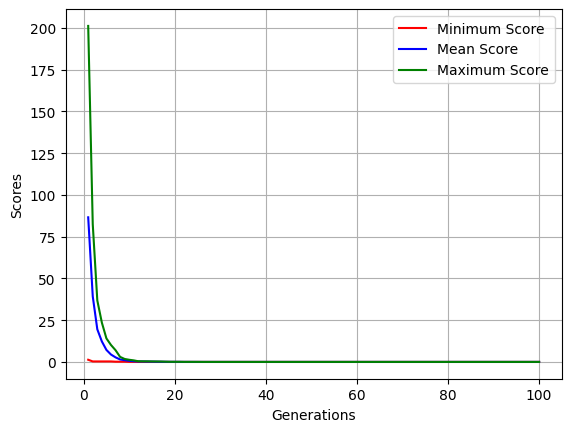

In [4]:
def f_Himmelblau(x):
    f1 = x[0]**2 + x[1] - 11
    f2 = x[0] + x[1]**2 - 7
    return f1**2 + f2**2

xrange = np.array([[-6, 6], [-6, 6]])
results = ga_opt(n = 2, func = f_Himmelblau, nparents = 50, rate_x = 0.5, ngen = 100, xrange = xrange, dx_ratio = 0.1)

print("Best x:", results['x'])
print("Best score:", results['s'])

s = results['s_keep']
generations = np.arange(1, ngen + 1)

plt.plot(generations, np.apply_along_axis(np.min, 1, s), color='red', label='Minimum Score')
plt.plot(generations, np.apply_along_axis(np.mean, 1, s), color='blue', label='Mean Score')
plt.plot(generations, np.apply_along_axis(np.max, 1, s), color='green', label='Maximum Score')
plt.xlabel('Generations')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()


# Travelling salesman problem (TSP) revisited

We again consider $n$ cities represented by the $x$ and $y$ coordinates in 2D. Our goal is to find the shortest route that travels each city exactly once and then return to the first city. Here, we will use genetic algorithm to find an heuristic optimal solution. This approach is related to the homework where you are asked to solve this problem by simulated annealing. The genetic representation $z$ is a vector of size $n$, corresponding to a permutation of city indices from 1 to $n$. The fitness function is the total distance going through all cities in the order specified by $z$. 

As we deal with a genetic representation of unique numbers and in a specific order, special choices of crossover and mutation operators are needed. For mutations, we consider two choices: *point mutation* where two randomly selected cities are swapped, and *inversion* where the city order between two randomly selected cities is reversed. 

In [5]:
import numpy as np

# Calculate the total distance given the order of cities.
def cal_s(n, d, z):
    # n: Number of cities.
    # d: Distance matrix (n by n).
    # z: A vector of cities (order, size n).
    # Returns: Total distance.
    dis = 0
    for i in range(n - 1):
        dis += d[z[i], z[i + 1]]
    dis += d[z[0], z[n - 1]]
    return dis

# Perform mutation by swapping the orders of two random cities.
def mut_point(n, z):
    # n: Number of cities.
    # z: A vector of cities (order, size n).
    # Returns: New order of cities.
    sites = np.random.choice(np.arange(n), 2, replace=False)
    znew = z.copy()
    znew[sites[0]], znew[sites[1]] = znew[sites[1]], znew[sites[0]]
    return znew

# Perform mutation by reversing the orders of two random cities.
def mut_inverse(n, z):
    # n: Number of cities.
    # z: A vector of cities (order, size n).
    # Returns: New order of cities.
    sites = np.random.choice(np.arange(n), 2, replace=False)
    znew = z.copy()
    znew[sites[0]:sites[1] + 1] = np.flip(znew[sites[0]:sites[1] + 1])
    return znew

# Crossover operators for set permutations

### Partially mixed crossover (PMX)

For crossover, many different methods have been proposed. One popular choice is called partially mapped crossover (PMX). After choosing two random cut points on parents to build offspring, the portion between the cut points, one parent’s string is mapped onto the other parent’s string and the remaining information is exchanged. Then we can fill further bits (from the original parents), for those which have no conflict. For those with conflict, we use the mapping from two parent's strings between the cut points. (see lecture notes for the examples) The implementation is a little complex for PMX. 

In [6]:
# Perform Partially Mapped Crossover (PMX) on two parent vectors.
def pmx(n, z1, z2):
    # n: Number of cities.
    # z1: Parent 1, a vector of cities (order, size n).
    # z2: Parent 2, a vector of cities (order, size n).
    # Returns: Tuple containing two new vectors of cities.
    z1_new = np.zeros(n, dtype=int)
    z2_new = np.zeros(n, dtype=int)
    sites = sorted(np.random.choice(np.arange(n), 2, replace=False))
    
    if sites[0] == 0 and sites[1] == n - 1:
        return z1.copy(), z2.copy()
    
    ind_list = np.setdiff1d(np.arange(n), np.arange(sites[0], sites[1] + 1))
    copied_z1 = z1[sites[0]:sites[1] + 1]
    copied_z2 = z2[sites[0]:sites[1] + 1]

    z1_new[sites[0]:sites[1] + 1] = copied_z2
    for i in ind_list:
        candidate = z1[i]
        while candidate in copied_z2:
            ind = np.where(copied_z2 == candidate)[0]
            candidate = copied_z1[ind][0]
        z1_new[i] = candidate
    
    z2_new[sites[0]:sites[1] + 1] = copied_z1
    for i in ind_list:
        candidate = z2[i]
        while candidate in copied_z1:
            ind = np.where(copied_z1 == candidate)[0]
            candidate = copied_z2[ind][0]
        z2_new[i] = candidate
    
    return z1_new, z2_new

### Order crossover (OX)

The second choice is order crossover (OX). It builds offspring by choosing a sub-tour of a parent and preserving the relative order of bits of the other parent. First, the bits are copied down between the cuts with similar way into the offspring. Second, starting from the second cut point of one parent, the bits from the other parent are copied in the same order omitting existing bits. Third, this sequence is placed in the first offspring starting from the second cut point. We repeat the same for the second offspring. 

In [7]:
# Perform Order Crossover (OX) on two parent vectors.
def ox(n, z1, z2):
    # n: Number of cities.
    # z1: Parent 1, a vector of cities (order, size n).
    # z2: Parent 2, a vector of cities (order, size n).
    # Returns: Tuple containing two new vectors of cities.
    z1_new = np.zeros(n, dtype=int)
    z2_new = np.zeros(n, dtype=int)
    sites = sorted(np.random.choice(np.arange(n), 2, replace=False))
    
    if sites[0] == 0 and sites[1] == n - 1:
        return z1.copy(), z2.copy()
    
    copied_z1 = z1[sites[0]:sites[1] + 1]
    copied_z2 = z2[sites[0]:sites[1] + 1]
    
    z2_ordered = np.concatenate((z2[sites[1] + 1:], z2[:sites[1] + 1]))
    fill_z2 = np.setdiff1d(z2_ordered, copied_z1)
    z2_new = np.concatenate((copied_z1, fill_z2))
    
    z1_ordered = np.concatenate((z1[sites[1] + 1:], z1[:sites[1] + 1]))
    fill_z1 = np.setdiff1d(z1_ordered, copied_z2)
    z1_new = np.concatenate((copied_z2, fill_z1))
    
    shift = sites[0]
    if shift > 0:
        z2_new = np.concatenate((z2_new[-shift:], z2_new[:-shift]))
        z1_new = np.concatenate((z1_new[-shift:], z1_new[:-shift]))
    
    return z1_new, z2_new

### Cycle crossover (CX)

The third choice is cycle crossover (CX). CX generates two offsprings where each bit with its position comes from one of the parents. The first bit for the offspring is selected randomly from the first or from the second parent. Now every bit in the offspring should be taken from one of its parents with the same position. Thus, due to the choice of the first bit, the city that was selected by the second offspring for the first bit can only be selected by the first offspring. We can continue the process until we complete a cycle and filling the remaining blank positions with the bits of those positions which are in second parent.

In [8]:
# Perform Cycle Crossover (CX) on two parent vectors.
def cx(n, z1, z2):
    # n: Number of cities.
    # z1: Parent 1, a vector of cities (order, size n).
    # z2: Parent 2, a vector of cities (order, size n).
    # Returns: Tuple containing two new vectors of cities.
    z1_new = np.zeros(n, dtype=int)
    z2_new = np.zeros(n, dtype=int)

    mask = np.zeros(n, dtype=bool)   # created to find unfilled positions
    mask[0] = True  # Start with the first city

    z1_new[0] = z1[0]
    ind = np.where(z1 == z2[0])[0][0]
    while not mask[ind]:
        z1_new[ind] = z1[ind]
        mask[ind] = True
        ind = np.where(z1 == z2[ind])[0][0]
    
    ind_rest = np.where(mask == 0)[0]
    z1_new[ind_rest] = z2[ind_rest]
    
    z2_new = z1 + z2 - z1_new

    return z1_new, z2_new

# Testing GA on various TSP cases.

Below, we test the mutation and crossover operators. We only select one mutation and one crossover for an GA application. It is also fine to use a mixture of different crossover/mutation operators. 


In [9]:
np.random.seed(1)

n = 8
z1 = np.array([2, 3, 7, 1, 6, 0, 5, 4])
z2 = np.array([3, 1, 4, 0, 5, 7, 2, 6])

print("Point Swapping Mutation:", mut_point(n, z1))
print("Inversion Mutation:", mut_inverse(n, z1))
print("PMX Crossover:", pmx(n, z1, z2))
print("OX Crossover:", ox(n, z1, z2))
print("CX Crossover (Same Vectors):", cx(n, z1, z2))

z1 = np.array([0, 1, 2, 3, 4, 5, 6, 7])
z2 = np.array([7, 4, 1, 0, 2, 3, 5, 6])
print("CX Crossover (different Vectors):", cx(n, z1, z2))

Point Swapping Mutation: [2 3 4 1 6 0 5 7]
Inversion Mutation: [2 3 1 7 6 0 5 4]
PMX Crossover: (array([3, 1, 4, 0, 6, 2, 5, 7]), array([2, 3, 7, 1, 5, 4, 0, 6]))
OX Crossover: (array([1, 3, 4, 5, 6, 7, 2, 0]), array([2, 3, 4, 6, 7, 0, 5, 1]))
CX Crossover (Same Vectors): (array([2, 3, 7, 1, 6, 0, 5, 4]), array([3, 1, 4, 0, 5, 7, 2, 6]))
CX Crossover (different Vectors): (array([0, 4, 1, 3, 2, 5, 6, 7]), array([7, 1, 2, 0, 4, 3, 5, 6]))


Below shows the GA function for the travelling salesman problem (TSP).


In [10]:
def tsp_ga(n, d, nparent, rate_x, ngen, func_x, func_m):
    # n: number of cities
    # d: distance matrix (n by n)
    # nparent: population size (even number)
    # rate_x: rate of crossover (vs. mutation)
    # ngen: number of generations
    # func_x: crossover function
    # func_m: mutation function

    nparent = nparent + nparent % 2  # Ensure nparent is even
    
    # Initial parent population
    z_parent = np.array([np.random.permutation(n) for _ in range(nparent)])
    s_parent = np.apply_along_axis(lambda z: cal_s(n, d, z), 1, z_parent)
    
    z_offspring = np.zeros((nparent, n), dtype=int)
    s_keep = np.zeros((ngen, nparent))
    
    for i in range(ngen):
        # New generation
        ind_ran = np.random.permutation(nparent)
        for j in range(nparent // 2):
            z1 = z_parent[ind_ran[2*j - 1]]
            z2 = z_parent[ind_ran[2*j]]
            if np.random.rand() < rate_x:
                # Crossover
                z_new = func_x(n, z1, z2)
                z_offspring[2*j - 1] = z_new[0]
                z_offspring[2*j] = z_new[1]
            else:
                # Mutation
                z_offspring[2*j - 1] = func_m(n, z1)
                z_offspring[2*j] = func_m(n, z2)
        
        # Scoring
        s_offspring = np.apply_along_axis(lambda z: cal_s(n, d, z), 1, z_offspring)
        
        # Selection
        z_all = np.concatenate((z_parent, z_offspring), axis=0)
        s_all = np.concatenate((s_parent, s_offspring))
        rank_all = np.argsort(np.argsort(s_all))
        ind_keep = np.where(rank_all < nparent)[0]
        
        z_parent = z_all[ind_keep]
        s_parent = s_all[ind_keep]
        
        z_best = z_all[np.where(rank_all == 0)]
        s_best = s_all[np.where(rank_all == 0)]
        s_keep[i] = s_parent
    
    return {'z': z_best, 's': s_best, 's_keep': s_keep}


First, we try the same 10 city example from the previous lecture. It works well to find the optimal solution using PMX and point mutation.

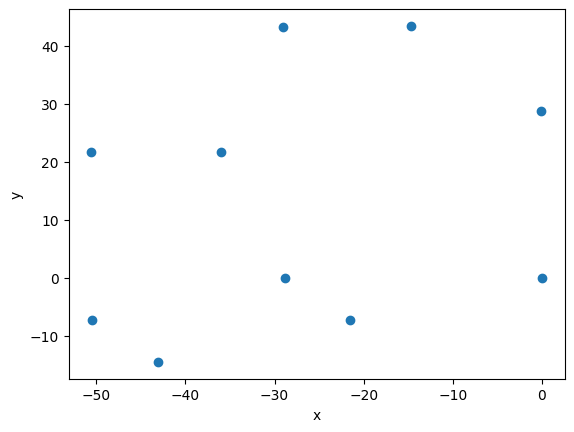

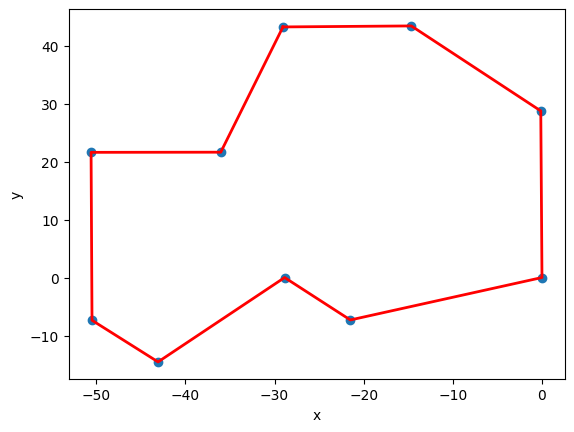

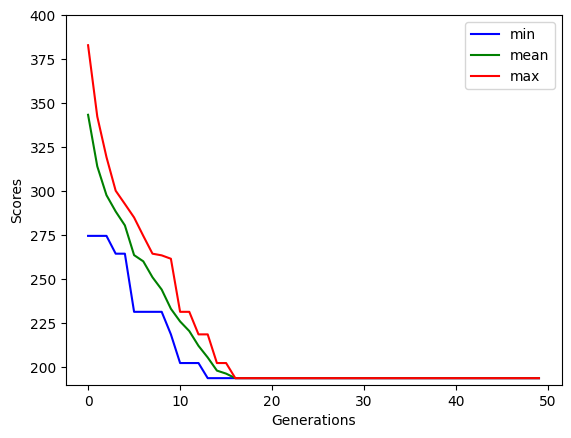

In [11]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform

# Read the data
np.random.seed(1)
c10 = pd.read_csv("./c10.txt", header=None, delimiter=r"\s+", names=["x", "y"])

plt.plot(c10['x'], c10['y'], marker='o', linestyle='None')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Compute distance matrix
d10 = squareform(pdist(c10))

# Run the genetic algorithm
ngen = 50
results = tsp_ga(n=10, d=d10, nparent=10, rate_x=0.8, ngen=ngen, func_x=pmx, func_m=mut_point)
p = results['z'][0]
p = np.concatenate((p, [p[0]]))

# Plot the tour
plt.plot(c10['x'], c10['y'], marker='o', linestyle='None')
plt.plot(c10['x'][p], c10['y'][p], 'r-', lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the scores
s = results['s_keep']
plt.plot(np.arange(ngen), np.apply_along_axis(np.min, 1, s), label='min', color='blue')
plt.plot(np.arange(ngen), np.apply_along_axis(np.mean, 1, s), label='mean', color='green')
plt.plot(np.arange(ngen), np.apply_along_axis(np.max, 1, s), label='max', color='red')
plt.xlabel('Generations')
plt.ylabel('Scores')
plt.ylim(190, 400)
plt.legend()
plt.show()

Second, we test the GA optimization on a model of 52 cities (*berlin52*). It's a much harder problem, and this time the solution is far from optimal using PMX and point mutation.


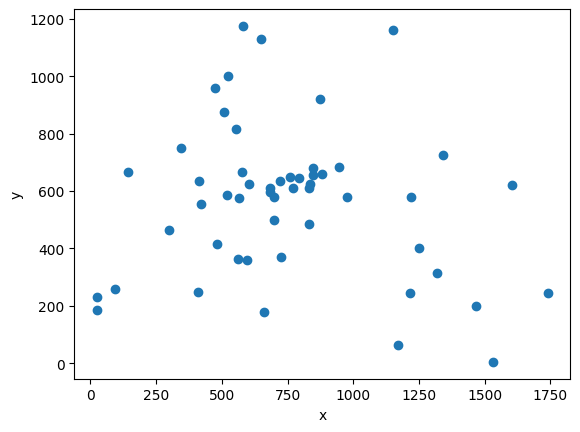

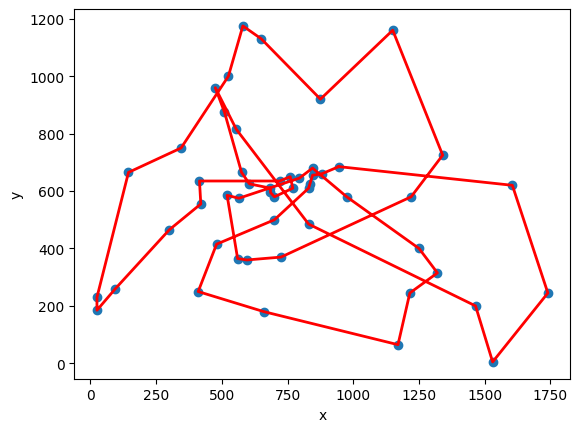

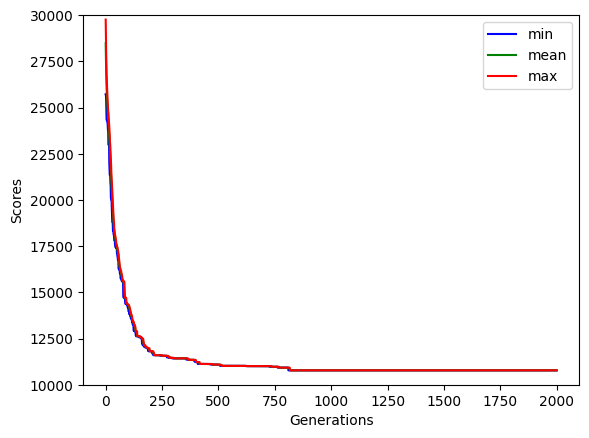

In [12]:
# Read the data
np.random.seed(1)
c52 = pd.read_csv("./berlin52.tsp", header=None, delimiter=r"\s+", names=["index", "x", "y"], index_col=0)
c52.index -= 1

plt.plot(c52['x'], c52['y'], marker='o', linestyle='None')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Compute distance matrix
d52 = squareform(pdist(c52))

# Run the genetic algorithm
ngen = 2000
results = tsp_ga(n=52, d=d52, nparent=40, rate_x=0.7, ngen=ngen, func_x=pmx, func_m=mut_point)
p = results['z'][0]
p = np.concatenate((p, [p[0]]))

# Plot the tour
plt.plot(c52['x'], c52['y'], marker='o', linestyle='None')
plt.plot(c52['x'][p], c52['y'][p], 'r-', lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the scores
s = results['s_keep']
plt.plot(np.arange(ngen), np.apply_along_axis(np.min, 1, s), label='min', color='blue')
plt.plot(np.arange(ngen), np.apply_along_axis(np.mean, 1, s), label='mean', color='green')
plt.plot(np.arange(ngen), np.apply_along_axis(np.max, 1, s), label='max', color='red')
plt.xlabel('Generations')
plt.ylabel('Scores')
plt.ylim(10000, 30000)
plt.legend()
plt.show()

When inversion operator is used, the solution is much improved. 

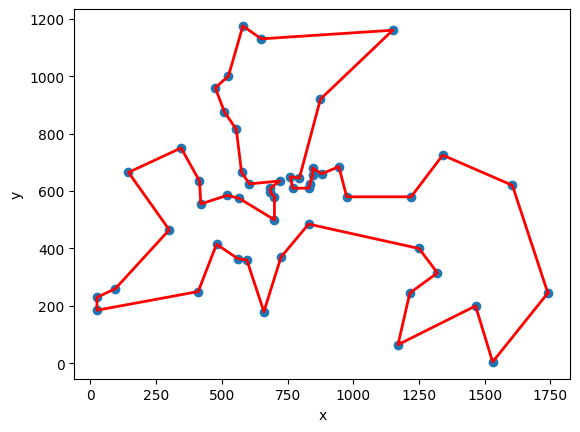

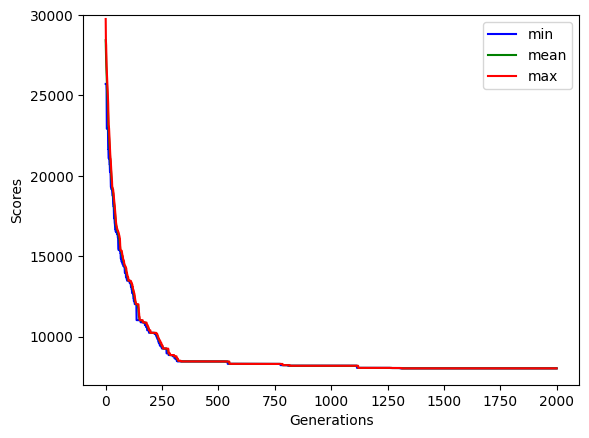

In [13]:
np.random.seed(1)

# Run the genetic algorithm
ngen = 2000
results = tsp_ga(n=52, d=d52, nparent=40, rate_x=0.6, ngen=ngen, func_x=pmx, func_m=mut_inverse)
p = results['z'][0]
p = np.concatenate((p, [p[0]]))

# Plot the tour
plt.plot(c52['x'], c52['y'], marker='o', linestyle='None')
plt.plot(c52['x'][p], c52['y'][p], 'r-', lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the scores
s = results['s_keep']
plt.plot(np.arange(ngen), np.apply_along_axis(np.min, 1, s), label='min', color='blue')
plt.plot(np.arange(ngen), np.apply_along_axis(np.mean, 1, s), label='mean', color='green')
plt.plot(np.arange(ngen), np.apply_along_axis(np.max, 1, s), label='max', color='red')
plt.xlabel('Generations')
plt.ylabel('Scores')
plt.ylim(7000, 30000)
plt.legend()
plt.show()

In this test with inversion and OX crossover, we find a very good solution. But finding this or better solutions are not guaranteed in our GA implementation. 

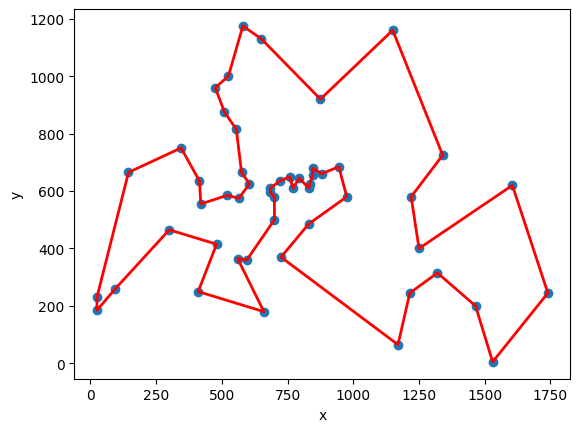

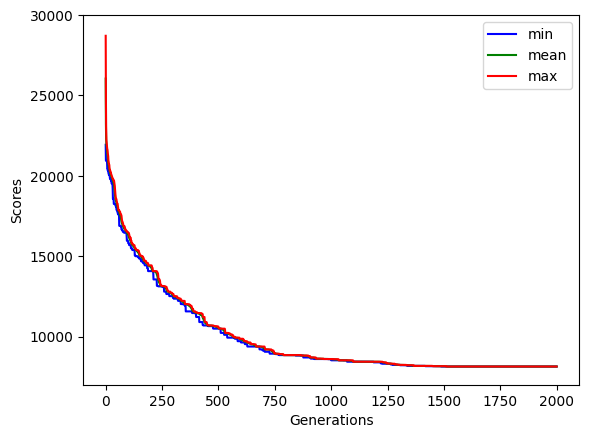

In [14]:
np.random.seed(1)

# Run the genetic algorithm
ngen = 2000
results = tsp_ga(n=52, d=d52, nparent=40, rate_x=0.7, ngen=ngen, func_x=ox, func_m=mut_inverse)
p = results['z'][0]
p = np.concatenate((p, [p[0]]))

# Plot the tour
plt.plot(c52['x'], c52['y'], marker='o', linestyle='None')
plt.plot(c52['x'][p], c52['y'][p], 'r-', lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the scores
s = results['s_keep']
plt.plot(np.arange(ngen), np.apply_along_axis(np.min, 1, s), label='min', color='blue')
plt.plot(np.arange(ngen), np.apply_along_axis(np.mean, 1, s), label='mean', color='green')
plt.plot(np.arange(ngen), np.apply_along_axis(np.max, 1, s), label='max', color='red')
plt.xlabel('Generations')
plt.ylabel('Scores')
plt.ylim(7000, 30000)
plt.legend()
plt.show()

When using CX crossover, we find similar results.

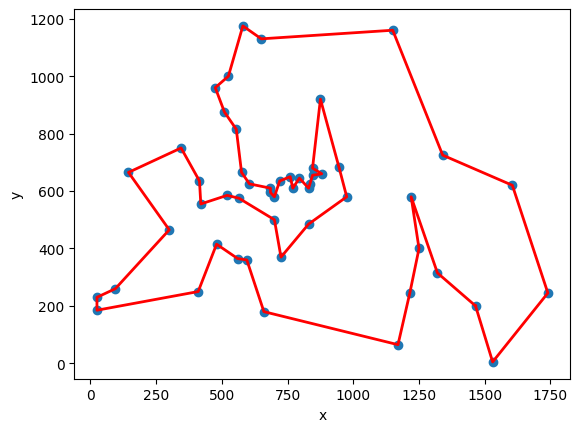

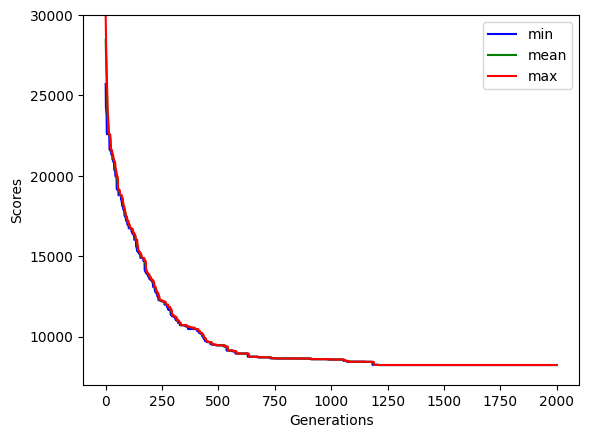

In [15]:
np.random.seed(1)

# Run the genetic algorithm
ngen = 2000
results = tsp_ga(n=52, d=d52, nparent=40, rate_x=0.7, ngen=ngen, func_x=cx, func_m=mut_inverse)
p = results['z'][0]
p = np.concatenate((p, [p[0]]))

# Plot the tour
plt.plot(c52['x'], c52['y'], marker='o', linestyle='None')
plt.plot(c52['x'][p], c52['y'][p], 'r-', lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the scores
s = results['s_keep']
plt.plot(np.arange(ngen), np.apply_along_axis(np.min, 1, s), label='min', color='blue')
plt.plot(np.arange(ngen), np.apply_along_axis(np.mean, 1, s), label='mean', color='green')
plt.plot(np.arange(ngen), np.apply_along_axis(np.max, 1, s), label='max', color='red')
plt.xlabel('Generations')
plt.ylabel('Scores')
plt.ylim(7000, 30000)
plt.legend()
plt.show()